## Plotting

In [1]:
%matplotlib widget

import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib.colorbar import ColorbarBase


# Plot settings
plt.rcParams['font.family'] = 'Roboto'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['legend.loc'] = 'lower center'
plt.rcParams['legend.frameon'] = False
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titley'] = 1.03
plt.rcParams['figure.subplot.left'] = 0.08
plt.rcParams['figure.subplot.right'] = 0.95
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['xtick.major.width'] = 2  # setting the x-axis tick width globally
plt.rcParams['ytick.major.width'] = 2 # setting the y-axis tick width globally
# Set fig size
plt.rcParams['figure.figsize'] = (12, 8)

Read everything from scenario folder

In [2]:
scenario_folder = r'C:\Users\wangy\OneDrive\ETHY2FW\IDP_Personal\CEA\2050 w3'
zone_gdf = gpd.read_file(scenario_folder + r'\inputs\building-geometry\zone.shp')
store_folder = './pareto_no_wood/pareto_no_wood_test'
zone_gdf.index = zone_gdf['Name']

# Create a new df using only the columns we need
zone_df = pd.DataFrame()
zone_df['Name'] = zone_gdf['Name']
zone_df.set_index('Name', inplace=True)

# Read typology file 
typology_df = gpd.read_file(scenario_folder + r'\inputs\building-properties\typology.dbf', ignore_geometry=True).set_index('Name')
zone_df = pd.concat([zone_df, typology_df['YEAR']], axis=1)
zone_gdf['area'] = zone_gdf['geometry'].area
zone_df = pd.concat([zone_df, zone_gdf['area'], zone_gdf['floors_ag']], axis=1)

# read the csv file containing if the building is inside district area
district_df = pd.read_csv(scenario_folder + r'\inputs\is_disheat.csv', index_col=0)
zone_df = zone_df.merge(district_df, left_index=True, right_index=True)

# Read the csv file containing if building is rebuilt
rebuild_df = pd.read_csv(scenario_folder + r'\inputs\Rebuild.csv', index_col=0)

zone_df = zone_df.merge(rebuild_df, left_index=True, right_index=True, how='left').fillna(0)

# Read the csv file containing if the building is renovated
renovate_df = pd.read_csv(scenario_folder + r'\inputs\Renovation.csv', index_col=0)

zone_df = zone_df.merge(renovate_df, left_index=True, right_index=True, how='left').fillna(0)

# Read dbf file containing current building systems
current_heating_system_df = gpd.read_file(scenario_folder + r'\inputs\building-properties\supply_systems.dbf', ignore_geometry=True).set_index('Name')[['type_hs']]
zone_df = zone_df.merge(current_heating_system_df, left_index=True, right_index=True, how='left')

# Add indicating columns to guide adjusting AttrDict based on building's status
zone_df['is_disheat'] = zone_df['DisHeat'].astype(bool)
zone_df['is_rebuilt'] = zone_df['Rebuild'].astype(bool)
zone_df['is_renovated'] = zone_df['Renovation'].astype(bool)
zone_df['is_new'] = ~zone_df['is_rebuilt'] & ~zone_df['is_renovated']
zone_df['already_GSHP'] = zone_df['type_hs'] == 'SUPPLY_HEATING_AS6'
zone_df['already_ASHP'] = zone_df['type_hs'] == 'SUPPLY_HEATING_AS7'
zone_df['no_heat'] = zone_df['type_hs'] == 'SUPPLY_HEATING_AS0'

# Get all dbfs from the following subfolder
dbf_folder = scenario_folder + r"\inputs\building-properties"
dbf_files = os.listdir(dbf_folder)
for file in dbf_files:
    if file.endswith(".dbf"):
        dbf_path = dbf_folder + "\\" + file
        df = gpd.read_file(dbf_path, ignore_geometry=True).set_index('Name')
        df.columns = [file[:-4] + "_" + col for col in df.columns]
        zone_df = pd.concat([zone_df, df], axis=1)

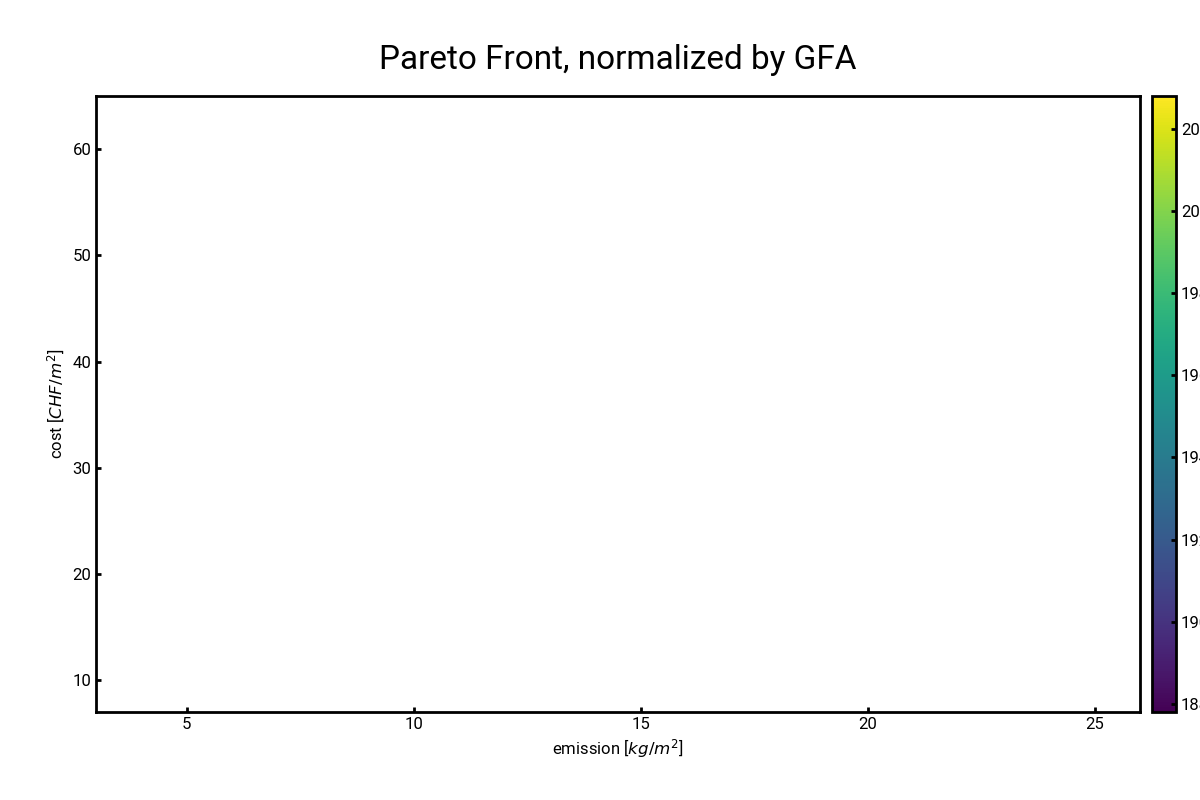

In [5]:
# Calculate the coefficient of variation of each technology choice for each building and store them in a dataframe; 
# in the end plot a bar chart with error bars for each technology in this dataframe.
# The dataframe should have columns as technology names, and rows as building names
# First define the dataframe column from one of the files in the folder;
# then iterate through the rest of the files and add the data to the dataframe
year_min = zone_df['YEAR'].min()
year_max = zone_df['YEAR'].max()
year_norm = mcolors.Normalize(vmin=year_min, vmax=year_max)
colormap = plt.get_cmap('viridis') # type: ignore
ls_csv = [csv for csv in os.listdir(store_folder) if csv.endswith('.csv')]
plt.figure()

# Initialize dataframe
df_tech_cap = pd.DataFrame()

for idx, csv in enumerate(ls_csv):
    if idx == 0:
        df_example = pd.read_csv(store_folder + '/' + csv, index_col=0, nrows=1)
        # add the first level index to be building name
        df_example.index = pd.MultiIndex.from_tuples([(csv, i) for i in df_example.index], names=['building', 'epsilon'])
        df_tech_cap = pd.DataFrame(columns=df_example.columns, index=df_example.index)
        df_tech_cap = df_tech_cap.dropna(how='all')

    building_sizing = pd.read_csv(store_folder + '/' + csv, index_col=0).fillna(0)
    # # calculate the coefficient of variation for each technology
    # df_tech_cap.loc[csv[:-10]] = building_sizing.std() / building_sizing.mean()
    building_name = csv[:-11]
    # if wood_boiler is 2000 at emission optimal (the first row), then it's oversized, change it to the DHW demand
    if building_sizing.loc[0, 'wood_boiler'] == 2000:
        building_sizing.loc[0, 'wood_boiler'] = building_sizing.loc[4, 'demand_hot_water']
        building_sizing.loc[0, 'DHDC_small_heat'] = 0
        building_sizing.loc[0, 'DHDC_medium_heat'] = 0
        building_sizing.loc[0, 'DHDC_large_heat'] = 0

    area_per_floor = pd.to_numeric(zone_df.loc[building_name, 'area'])
    n_floor = pd.to_numeric(zone_df.loc[building_name, 'floors_ag'])
    if pd.isna(area_per_floor) or pd.isna(n_floor): # check if the area_per_floor or n_floor is NaN
        raise ValueError(f"Invalid numeric values for building '{building_name}'")
    building_area = area_per_floor * n_floor
    # calculate the sizing per m2
    building_sizing_per_m2 = building_sizing / building_area
    # add the first level index to be building name
    building_sizing_per_m2.reset_index(drop=True, inplace=True)
    building_sizing_per_m2.index = pd.MultiIndex.from_product([[building_name], building_sizing_per_m2.index], names=['building', 'epsilon'])

    # add the building_sizing_per_m2 to df_tech_cap to the bottom, but keep the multiindex
    df_tech_cap = pd.concat([df_tech_cap, building_sizing_per_m2], axis=0)

    building_year = zone_df.loc[building_name, 'YEAR']
    building_color = colormap(year_norm(building_year))
    df_pareto = df_tech_cap.loc[building_name]
    plt.plot(df_pareto['emission'].iloc[1:], df_pareto['cost'].iloc[1:], label=building_name, marker='.', color=building_color, linewidth=0.75)

# Plot final graph
plt.ylabel('cost [$CHF/m^2$]')
plt.xlabel('emission [$kg/m^2$]')
plt.title('Pareto Front, normalized by GFA', fontsize=24)
plt.ylim(7, 65)
plt.xlim(3, 26)

cax = plt.axes((0.96, 0.11, 0.02, 0.77))
cbar = ColorbarBase(cax, cmap=colormap, norm=year_norm)
cbar.ax.set_ylabel('year of built')

plt.show()

In [7]:
plt.figure(figsize=(5,8))
for building_name in df_tech_cap.index.get_level_values('building').unique():
    # get the df_pareto for this building
    df_pareto = df_tech_cap.loc[building_name]
    # the first point is emission minimal, thus cost maximal; 
    # last one is cost minimal, thus emission maximal
    # the slope defines how hard it is to reduce emission when sliding from cost minimal to emission minimal
    y1 = df_pareto['cost'].iloc[0]
    y2 = df_pareto['cost'].iloc[3]
    x1 = df_pareto['emission'].iloc[0]
    x2 = df_pareto['emission'].iloc[3]
    emission_reduction_relative = (x2-x1)/x1*100 # percentage of emission reduction
    cost_increase_absolute = y1-y2 # absolute cost increase
    # label the points with building name next to the points
    building_year = zone_df.loc[building_name, 'YEAR']
    # building_area = zone_df.loc[building_name, 'area'] * zone_df.loc[building_name, 'floors_ag']
    building_color = colormap(year_norm(building_year))
    # find building typology 
    plt.scatter(cost_increase_absolute, emission_reduction_relative, label=building_name, marker='o', color=building_color) # type: ignore
    # annotate the building name next to the point
    if zone_df.loc[building_name, 'typology_1ST_USE'] not in ['SINGLE_RES', 'MULTI_RES']:
        plt.annotate(str(zone_df.loc[building_name, 'typology_1ST_USE']), (cost_increase_absolute, emission_reduction_relative), 
                     fontsize=8, xytext=(0, 5), textcoords='offset points', ha='left')
    
plt.ylabel('Percentage of emission reduction [%]')
plt.xlabel('Additional cost to reduce emission [$CHF/m^2$]')
plt.xlim(0, 150)
plt.ylim(0, 40)
# plot a line from (0,0) to (100, 1) and extend to the right
plt.plot([0, 75], [0, 40], color='k', linestyle='--', linewidth=0.5)
plt.plot([0, 150], [0, 40], color='k', linestyle='--', linewidth=0.5)
plt.plot([0, 250], [0, 40], color='k', linestyle='--', linewidth=0.5)
plt.plot([0, 400], [0, 40], color='k', linestyle='--', linewidth=0.5)

# plot a horizontal line at 800
# plt.axhline(y=900, color='k', linestyle='--', linewidth=0.5)
# plt.axhline(y=530, color='k', linestyle='--', linewidth=0.5)
plt.title('Fraction of total emission reduction', fontsize=24)

# again, plot a colorbar next to the plot, with the same height as the plot box
cax = plt.axes((0.96, 0.11, 0.02, 0.77))
cbar = ColorbarBase(cax, cmap=colormap, norm=year_norm)
# label the building year on the left of the colorbar
cbar.ax.set_ylabel('year of built')

plt.savefig(r'C:\Users\wangy\polybox - Yiqiao Wang (yiqwang@student.ethz.ch)@polybox.ethz.ch\Final Report\Graphics\relative_{}_thinner.pdf'.format(store_folder[9:]), dpi=300, bbox_inches='tight')
plt.show()

NameError: name 'df_tech_cap' is not defined

<Figure size 500x800 with 0 Axes>

In [ ]:
plt.figure(figsize=(5,8))
for building_name in df_tech_cap.index.get_level_values('building').unique():
    # get the df_pareto for this building
    df_pareto = df_tech_cap.loc[building_name]
    # the first point is emission minimal, thus cost maximal; 
    # last one is cost minimal, thus emission maximal
    # the slope defines how hard it is to reduce emission when sliding from cost minimal to emission minimal
    y1 = df_pareto['cost'].iloc[0]
    y2 = df_pareto['cost'].iloc[3]
    x1 = df_pareto['emission'].iloc[0]
    x2 = df_pareto['emission'].iloc[3]
    emission_reduction_absolute = x2-x1 # percentage of emission reduction
    cost_increase_absolute = y1-y2 # absolute cost increase
    # label the points with building name next to the points
    building_year = zone_df.loc[building_name, 'YEAR']
    # building_area = zone_df.loc[building_name, 'area'] * zone_df.loc[building_name, 'floors_ag']
    building_color = colormap(year_norm(building_year))
    # find building typology 
    plt.scatter(cost_increase_absolute, emission_reduction_absolute, label=building_name, marker='o', color=building_color) # type: ignore
    # annotate the building name next to the point
    if zone_df.loc[building_name, 'typology_1ST_USE'] not in ['SINGLE_RES', 'MULTI_RES']:
        plt.annotate(str(zone_df.loc[building_name, 'typology_1ST_USE']), (cost_increase_absolute, emission_reduction_absolute), 
                     fontsize=8, xytext=(0, 5), textcoords='offset points', ha='left')
    
plt.ylabel('Absolute emission reduction [$kg/m^2$]')
plt.xlabel('Additional cost to reduce emission [$CHF/m^2$]')
plt.xlim(0, 150)
plt.ylim(0, 2.25)
# set y ticks to tick only every 0.5
plt.yticks(np.arange(0, 2.25, 0.5))
# plot a line from (0,0) to (100, 1) and extend to the right
plt.plot([0, 75], [0, 2.25], color='k', linestyle='--', linewidth=0.5)
plt.plot([0, 150], [0, 2.25], color='k', linestyle='--', linewidth=0.5)
plt.plot([0, 250], [0, 2.25], color='k', linestyle='--', linewidth=0.5)
plt.plot([0, 400], [0, 2.25], color='k', linestyle='--', linewidth=0.5)

# plot a horizontal line at 800
# plt.axhline(y=900, color='k', linestyle='--', linewidth=0.5)
# plt.axhline(y=530, color='k', linestyle='--', linewidth=0.5)
plt.title('Total emission reduction', fontsize=24)

# again, plot a colorbar next to the plot, with the same height as the plot box
cax = plt.axes((0.96, 0.11, 0.02, 0.77))
cbar = ColorbarBase(cax, cmap=colormap, norm=year_norm)
# label the building year on the left of the colorbar
cbar.ax.set_ylabel('year of built')

plt.savefig(r'C:\Users\wangy\polybox - Yiqiao Wang (yiqwang@student.ethz.ch)@polybox.ethz.ch\Final Report\Graphics\absolute_{}_thinner.pdf'.format(store_folder[9:]), dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
for building_name in df_tech_cap.index.get_level_values('building').unique():
    # get the df_pareto for this building
    df_pareto = df_tech_cap.loc[building_name]
    # the first point is emission minimal, thus cost maximal; 
    # last one is cost minimal, thus emission maximal
    # the slope defines how hard it is to reduce emission when sliding from cost minimal to emission minimal
    y1 = df_pareto['cost'].iloc[1]
    y2 = df_pareto['cost'].iloc[4]
    x1 = df_pareto['emission'].iloc[1]
    x2 = df_pareto['emission'].iloc[4]
    slope = -(y2-y1)/(x2-x1)
    average_emission = (df_pareto['emission'].iloc[-3] + df_pareto['emission'].iloc[1]) / 2
    # label the points with building name next to the points
    building_year = zone_df.loc[building_name, 'YEAR']
    # building_area = zone_df.loc[building_name, 'area'] * zone_df.loc[building_name, 'floors_ag']
    building_color = colormap(year_norm(building_year))
    # find building typology 
    plt.scatter(average_emission, slope, label=building_name, marker='o', color=building_color) # type: ignore
    # annotate the building name next to the point
    if zone_df.loc[building_name, 'typology_1ST_USE'] not in ['SINGLE_RES', 'MULTI_RES']:
        plt.annotate(str(zone_df.loc[building_name, 'typology_1ST_USE']), (average_emission, slope), 
                     fontsize=8, xytext=(0, 5), textcoords='offset points', ha='left')
    # add name of the building next to the point
    # plt.annotate(building_name, (average_emission, slope), fontsize=8, xytext=(0, 5), textcoords='offset points', ha='left')
    
plt.ylabel('Elasticity of cost to emission [-]')
plt.xlabel('Average emission [$kg/m^2$]')
# plt.xlim(3, 26)
# plt.ylim(1.8, 4.9)
# plot a horizontal line at 800
# plt.axhline(y=900, color='k', linestyle='--', linewidth=0.5)
# plt.axhline(y=530, color='k', linestyle='--', linewidth=0.5)
plt.title('Difficulties for buildings to reduce emission', fontsize=24)

# again, plot a colorbar next to the plot, with the same height as the plot box
cax = plt.axes((0.96, 0.11, 0.02, 0.77))
cbar = ColorbarBase(cax, cmap=colormap, norm=year_norm)
# label the building year on the left of the colorbar
cbar.ax.set_ylabel('year of built')

# plt.savefig(r'C:\Users\wangy\polybox - Yiqiao Wang (yiqwang@student.ethz.ch)@polybox.ethz.ch\Final Report\Graphics\ParetoFront_elasticity_{}.pdf'.format(store_folder[9:]), dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Separate the demand technologies
df_demand_tech = df_tech_cap[df_tech_cap.columns[-4:]]
df_supply_tech = df_tech_cap[df_tech_cap.columns[:-4]]

# Create a figure with two subplots side by side, with a shared y-axis and width ratio of 3:1
fig, axs = plt.subplots(1, 2, sharey=True,figsize=(20, 6), gridspec_kw={'width_ratios': [4, 1]})

# Boxplot without outliers and with a custom hatch pattern
boxprops = dict(linestyle='-', linewidth=1, color='k')  # Custom box properties
medianprops = dict(linestyle='-', linewidth=0.5, color='k')  # Custom median properties

# Create a color map for the five epsilon cuts
# 5 distinct colors for 5 epsilon cuts
cmap = plt.get_cmap('RdYlGn', 5) # type: ignore
# reverse the color map so that the emission optimal is green
cmap = cmap.reversed()

# Create a boxplot for each technology
for i, tech in enumerate(df_supply_tech.columns):
    # Get the data for the current technology
    # Reshape the data to have 5 rows for each technology
    tech_data = df_supply_tech[tech].values.reshape((-1, 5))  # type: ignore
    bp = axs[0].boxplot(tech_data, positions=np.arange(i*5, i*5+5), patch_artist=True, showfliers=False, boxprops=boxprops, medianprops=medianprops)

    # Fill each box with a color according to its epsilon cut
    for j, box in enumerate(bp['boxes']):
        box.set(facecolor=cmap(j))

# Define your colors for the demand technologies
demand_colors = ['tab:green', 'tab:orange', 'tab:blue', 'tab:red']

# Create a boxplot for each demand technology, but only one box per technology
for i, tech in enumerate(df_demand_tech.columns):
    # calculate the mean of each technology in five epsilon cuts
    tech_data = df_demand_tech[tech].values.reshape(-1, 5).mean(axis=1) # type: ignore
    bp = axs[1].boxplot(tech_data, positions=[i], patch_artist=True, showfliers=False, boxprops=boxprops, medianprops=medianprops, widths=0.5)  # Set position to a single value and adjust the width
    # Fill each box with a color according to its epsilon cut
    for j, box in enumerate(bp['boxes']):
        box.set(facecolor=demand_colors[i])

# Set the x-axis labels to the technology names
axs[0].set_xticks(np.arange(2.5, len(df_supply_tech.columns)*5, 5))  # Set x-ticks to the middle box of each technology group
axs[0].set_xticklabels(df_supply_tech.columns, rotation=45)

# Align the x-axis labels to the right
for label in axs[0].get_xticklabels():
    label.set_horizontalalignment('right')

# Draw vertical lines to separate the technologies inbetween the boundary boxes, not on the box
for i in range(5, len(df_supply_tech.columns)*5, 5):
    axs[0].axvline(x=i-0.5, color='k', linestyle='--', linewidth=0.5)  # Subtract 0.5 from the x position

# set the second subplot's x axis to be the same as the first one, but only one box per technology
axs[1].set_xticks(range(len(df_demand_tech.columns)))  # Set x-ticks to the middle box of each technology group
axs[1].set_xticklabels(df_demand_tech.columns, rotation=45)

for label in axs[1].get_xticklabels():
    label.set_horizontalalignment('right')
# Set the title and axis labels
axs[0].set_title('Variation of Building Technologies', fontsize=24)
axs[1].set_title('Variation of Demand', fontsize=24)
axs[0].set_ylabel('Specific Sizing of Technologies [$kW/m^2$]', fontsize=14)

# Create a custom legend for the epsilon cuts
ls_epsilon_cut = ['Emission Optimal', 'Epsilon 1', 'Epsilon 2', 'Epsilon 3', 'Cost Optimal']
legend_patches = [mpatches.Patch(color=cmap(i), label=ls_epsilon_cut[i]) for i in range(5)]
axs[0].legend(handles=legend_patches, loc='upper left')

# print a horizontal line at 0 for both subplots
axs[0].axhline(y=0, color='k', linestyle='--', linewidth=0.5)
axs[1].axhline(y=0, color='k', linestyle='--', linewidth=0.5)

# Set the y-axis limits
axs[0].set_ylim(-0.005, 0.09)
# make the two plots a bit closer
plt.subplots_adjust(wspace=0.05)
# Tight layout to adjust padding
# plt.tight_layout()

plt.savefig(r'C:\Users\wangy\polybox - Yiqiao Wang (yiqwang@student.ethz.ch)@polybox.ethz.ch\Final Report\Graphics\Variation_{}_shorter.pdf'.format(store_folder[9:]), dpi=300, bbox_inches='tight')
# Show the plot
plt.show()

## explore different clustering of building against pareto front
1. The goal is to compare buildings with different DH capex. If five buildings are using the same DH outlet, then every building should only share 1/5 of the DH capex. 
2. There are some buildings that belongs to the same developer. These buildings can be clustered and share the DH capex. Below I will list the buildings that belongs to the same developer.

In [ ]:
# # define the buildings with the same developer, and they will devide the DH capex equally
# # first group: B302065793, B302065787, B302065792, B302065794, B302065791, B302065789
# # second group: B162597, B162593, B162591, B162595, B162600
# # third group: B162588, B162587, B162581
# # fourth group: B302022561, B302022562
# # fifth group: B302021386, B302021387, B302021388
# # sixth group: B162416, 162422
# # seventh group: B302024523, B302024524
# # eighth group: B302030821, B302030823, B302030825, B302030820, B302030824, B302030818, B302030819
# # ninth group: B162917, B162920
# # tenth group: B162932, B162933
# # eleventh group: B162334, B162335, B162332, B162338
# # twelfth group: B162372, B162382, B162376, B162393, B162462, B162465, B162467, B162379, B162378, B162381, B162394, B162396
# # thirteenth group: B162397, B162398, B162399
# # fourteenth group: B302066076, B302066077
# # fifteenth group: B302065980, B302065981
# # sixteenth group: B302030808, B302030809, B302030810, B302030807, B302030811, B302030812, B302030813
# # seventeenth group: B302012571, B302012572, B302012573, B162602, B2365744, B2365747
# # eighteenth group: B302066212, B3020662121
# # nineteenth group: B162618, B162619, B162620, B162621, B162622, B162623
# # twentieth group: B162605, B162606
# # twenty-first group: B162473, B162475, B162477, B162479, B162481

# # create a dictionary to store the building names in each group
# dict_group = {'group1': ['B302065793', 'B302065787', 'B302065792', 'B302065794', 'B302065791', 'B302065789'],
#               'group2': ['B162597', 'B162593', 'B162591', 'B162595', 'B162600'],
#               'group3': ['B162588', 'B162587', 'B162581'],
#               'group4': ['B302022561', 'B302022562'],
#               'group5': ['B302021386', 'B302021387', 'B302021388'],
#               'group6': ['B162416', '162422'],
#               'group7': ['B302024523', 'B302024524'],
#               'group8': ['B302030821', 'B302030823', 'B302030825', 'B302030820', 'B302030824', 'B302030818', 'B302030819'],
#               'group9': ['B162917', 'B162920'],
#               'group10': ['B162932', 'B162933'],
#               'group11': ['B162334', 'B162335', 'B162332', 'B162338'],
#               'group12': ['B162372', 'B162382', 'B162376', 'B162393', 'B162462', 'B162465', 'B162467', 'B162379', 'B162378', 'B162381', 'B162394', 'B162396'],
#               'group13': ['B162397', 'B162398', 'B162399'],
#               'group14': ['B302066076', 'B302066077'],
#               'group15': ['B302065980', 'B302065981'],
#               'group16': ['B302030808', 'B302030809', 'B302030810', 'B302030807', 'B302030811', 'B302030812', 'B302030813'],
#               'group17': ['B302012571', 'B302012572', 'B302012573', 'B162602', 'B2365744', 'B2365747'],
#               'group18': ['B302066212', 'B3020662121'],
#               'group19': ['B162618', 'B162619', 'B162620', 'B162621', 'B162622', 'B162623'],
#               'group20': ['B162605', 'B162606'],
#               'group21': ['B162473', 'B162475', 'B162477', 'B162479', 'B162481']
#               }